## EDR3 and DR3 Mean source photometry uncertainty vs magnitude

This notebook shows how to estimate the expected uncertainties on the (E)DR3 photometry in the $G$, $G_\textrm{BP}$, and $G_\textrm{RP}$ bands based on cubic B-splines fitted to the (E)DR3 log(mag) uncertainties. The splines were fitted to the mode of the log(mag) uncertainty vs magnitude distributions for sources with number of observations (CCD transits) $N_\textrm{obs, G}=200$, $N_\textrm{obs, BP/RP}=20$ shown in [figure 14](https://www.aanda.org/articles/aa/full_html/2021/05/aa39587-20/F14.html) of the DPAC EDR3 photometry paper ([Riello et al. 2021](https://www.aanda.org/articles/aa/full_html/2021/05/aa39587-20/aa39587-20.html)).
For each band the fit was restricted to the magnitude range $4\leq m_b\leq21$ mag in the corresponding band $b\in(G, G_\textrm{BP}, G_\textrm{RP})$.

The spline knots and coefficients are supplied by DPAC as a CSV file. The python 3 class below can be used to estimate the uncertainties in a given band and for a given (set of) number of observations. The result is provided as a [Pandas DataFrame](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html).

Note that these uncertainties do not take into account systematic effects remaining in the data that originate in the properties of the source e.g. magnitude and colour. Systematic effects remaining in the data that vary with each CCD or FoV are accounted for by this tool and can be scaled to future releases with the understanding that these systematic effects will be reduced. We recommend reading [Riello et al. 2021](https://www.aanda.org/articles/aa/full_html/2021/05/aa39587-20/aa39587-20.html) and [Fabricius et al 2021](https://www.aanda.org/articles/aa/full_html/2021/05/aa39834-20/aa39834-20.html) for getting a better understanding of the remaining systematics within the (E)DR3 photometry.

In [1]:
import pandas as pd
import numpy as np
import scipy.interpolate as interpolate

class Edr3LogMagUncertainty:
    """
    Estimate the log(mag) vs mag uncertainty for G, G_BP, G_RP based on Gaia EDR3 photometry.
    """
    
    def __init__(self, spline_csv):
        """
        """
        _df = pd.read_csv(spline_csv)
        splines = dict()
        splines['g'] = self.__init_spline(_df, 'knots_G', 'coeff_G')
        splines['bp'] = self.__init_spline(_df, 'knots_BP', 'coeff_BP')
        splines['rp'] = self.__init_spline(_df, 'knots_RP', 'coeff_RP')
        self.__splines = splines
        self.__nobs = {'g': 200, 'bp': 20, 'rp': 20}
    
    def estimate(self, band, nobs: np.array([], int) = 0, mag_range=None, mag_samples=1000):
        """
        Estimate the log(mag) vs mag uncertainty
        
        Parameters
        ----------
        band : str
            name of the band for which the uncertainties should be estimated (case-insentive)
        nobs : ndarray, int
            number of observations for which the uncertainties should be estimated.
            Must be a scalar integer value or an array of integer values.
        mag_range : array_like
            Magnitude range over which the spline should be evaluated.
            The default and maximum valid range is (4, 21)
        mag_samples : int
            Number evenly spaced magnitudes (over the mag_range interval) at which the splines 
            will be estimated. Default: 1000
        
        Returns
        -------
        df : DataFrame
            Pandas dataframe with the interpolated log(mag) uncertainty vs mag.
            The magnitude column is named mag_g, mag_bp, or mag_rp depending of the requested band.
            A column for each value of nobs is provided, in the default case the column is logU_200.
        """
        band = band.lower()
        if band not in ['g', 'bp', 'rp']:
            raise ValueError(f'Unknown band: {band}')
        if mag_range is None:
            mag_range = (4., 21.)
        else:
            if mag_range[0] < 4.:
                raise ValueError(f'Uncertainties can be estimated on in the range {band}[4, 21]')
            elif mag_range[1] > 21.:
                raise ValueError(f'Uncertainties can be estimated on in the range {band}[4, 21]')
            elif mag_range[0] > mag_range[1]:
                raise ValueError('Malformed magnitude range')
        #
        xx = np.linspace(mag_range[0], mag_range[1], mag_samples)
        __cols = self.__compute_nobs(band, xx, nobs)
        __dc = {f'mag_{band}': xx, **__cols}
        return pd.DataFrame(data=__dc)
    
    def __init_spline(self, df, col_knots, col_coeff):
        __ddff = df[[col_knots, col_coeff]].dropna()
        return interpolate.BSpline(__ddff[col_knots], __ddff[col_coeff], 3, extrapolate=False)
    
    def __compute_nobs(self, band, xx, nobs):
        if isinstance(nobs, int):
            nobs = [nobs]
        __out = dict()
        for num in nobs:
            if num < 0:
                raise ValueError(f'Number of observations should be strictly positive')
            if num == 0:
                __out[f'logU_{self.__nobs[band]:d}'] = self.__splines[band](xx)
            else:
                __out[f'logU_{num:d}'] = self.__splines[band](xx) - np.log10(np.sqrt(num) / np.sqrt(self.__nobs[band]))
        return __out

## Usage

The `Edr3LogMagUncertainty` class is instantiated by providing the location of the CSV file containing the spline knots and coefficients. The uncertainties in a given band can then be computed using the `estimate` method which 
takes the following arguments:

* `band`: name of the band (case insensitive) for which the uncertainties are required.
* `nobs`: (optional) number of observations for which the uncertainties should be estimated. The default value is 200 (which is also used if entering a value equal to zero or none). The argument can accept also an array of values to compute the expected uncertainties for multiple values of the number of observations.
* `mag_range`: (optional) magnitude range over which the spline should be evaluated. The default and maximum valid range is `(4, 21)`.
* `mag_samples`: (optional) number evenly spaced magnitudes (over the `mag_range` interval) at which the splines will be estimated.

The method returns a Pandas `DataFrame` containing:

* A column with the magnitude at which the uncertainty is provided, named `mag_g`, `mag_bp`, or `mag_rp` depending on which band was requested.
* A column for each of the requested `nobs` values, named as `logU_N` where `N` is the number of observations (e.g. `logU_200` in the default case)

## Examples

### Uncertainties vs magnitude for all bands and $N_\textrm{obs, G}=200$, $N_\textrm{obs, BP/RP}=20$

The code snippet below show how to estimate the expected uncertainties for sources with 200 observation in $G$, $G_\textrm{BP}$, and $G_\textrm{RP}$ respectively and plotting the results.

In [2]:
u = Edr3LogMagUncertainty('LogErrVsMagSpline.csv')
g200 = u.estimate('g')
b20 = u.estimate('bp')
r20 = u.estimate('rp')

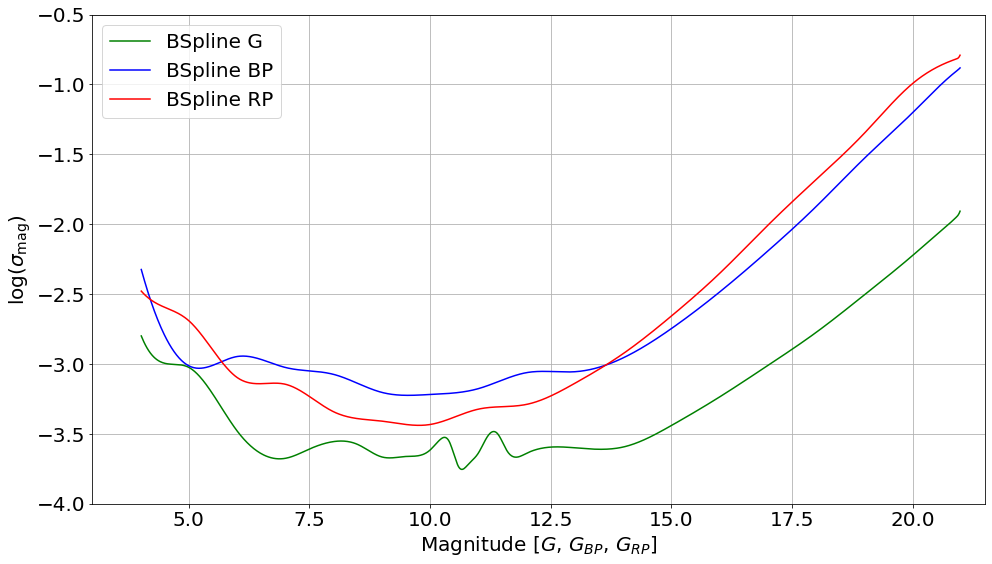

In [3]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(16,9))
ax.plot(g200['mag_g'], g200['logU_200'], color='green', label='BSpline G')
ax.plot(b20['mag_bp'], b20['logU_20'], color='blue', label='BSpline BP')
ax.plot(r20['mag_rp'], r20['logU_20'], color='red', label='BSpline RP')
plt.xlim(3, 21.5)
plt.ylim(-4, -0.5)
plt.legend(loc='best', prop={'size': 20})
plt.xlabel("Magnitude [$G$, $G_{BP}$, $G_{RP}$]", size=20)
plt.ylabel("$\log(\sigma_{\\rm{ mag}})$", size=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid()

### $G$-band uncertainties vs magnitude for different values of $N_\textrm{obs}$

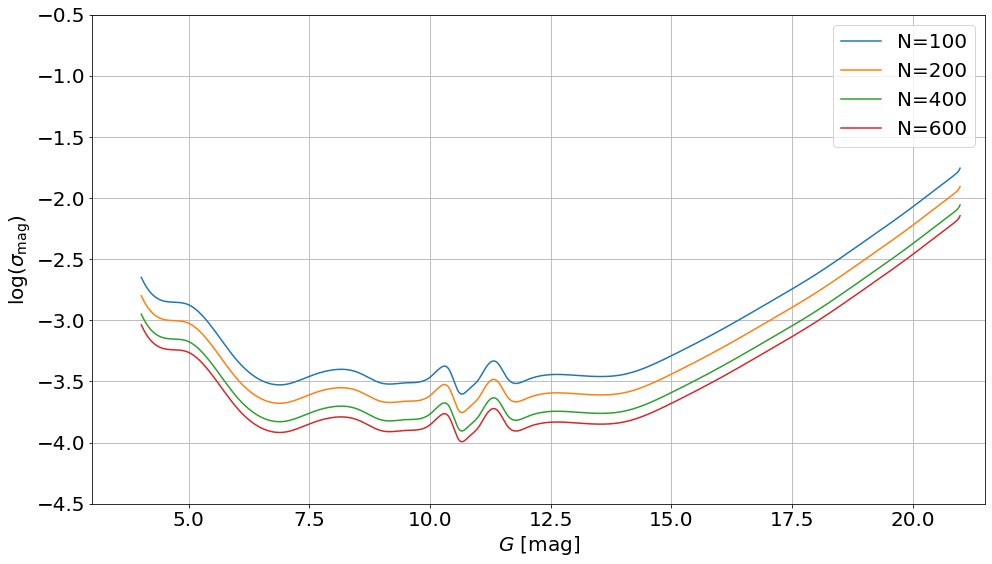

In [4]:
nobs = [100, 200, 400, 600]
udf = u.estimate('g', nobs=nobs)

fig, ax = plt.subplots(1, 1, figsize=(16,9))
for n in nobs:
    ax.plot(udf['mag_g'], udf[f'logU_{n:d}'], '-', label=f'N={n}')
plt.xlim(3, 21.5)
plt.ylim(-4.5, -0.5)
plt.legend(loc='best', prop={'size': 20})
plt.xlabel("$G$ [mag]", size=20)
plt.ylabel("$\log(\sigma_{\\rm{ mag}})$", size=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.grid()

### $G_{\rm BP}$-band uncertainties vs magnitude for different values of $N_\textrm{obs}$

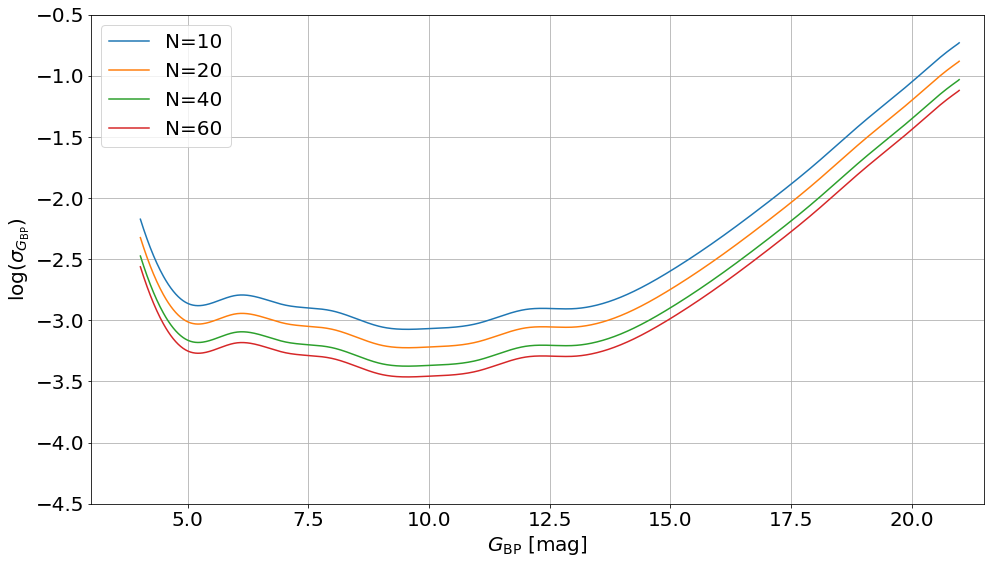

In [5]:
nobs = [10, 20, 40, 60]
udf = u.estimate('bp', nobs=nobs)

fig, ax = plt.subplots(1, 1, figsize=(16,9))
for n in nobs:
    ax.plot(udf['mag_bp'], udf[f'logU_{n:d}'], '-', label=f'N={n}')
plt.xlim(3, 21.5)
plt.ylim(-4.5, -0.5)
plt.legend(loc='best', prop={'size': 20})
plt.xlabel("$G_{\\rm{BP}}$ [mag]", size=20)
plt.ylabel("$\log(\sigma_{G_{\\rm{ BP}}})$", size=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid()

### $G_{\rm RP}$-band uncertainties vs magnitude for different values of $N_\textrm{obs}$

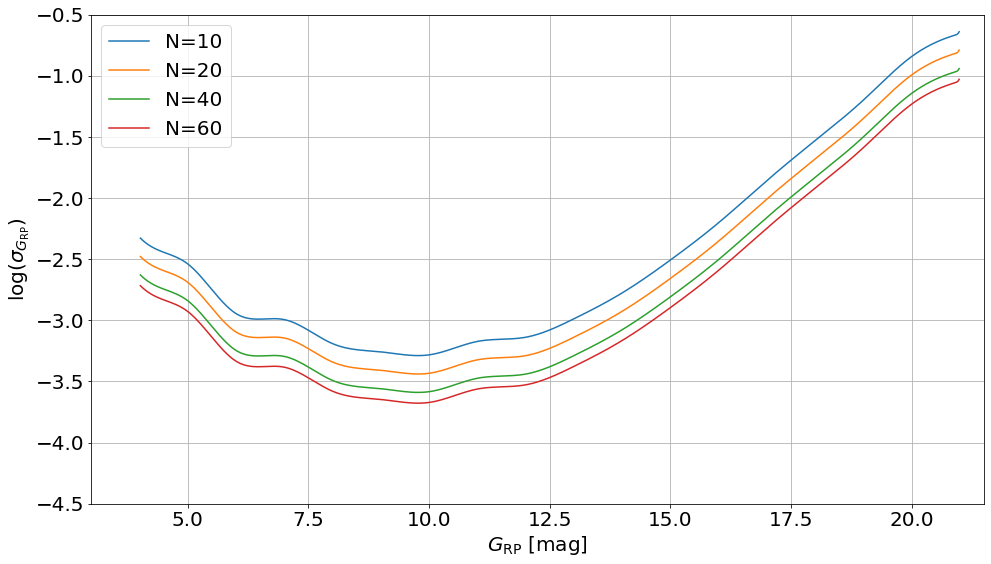

In [6]:
nobs = [10, 20, 40, 60]
udf = u.estimate('rp', nobs=nobs)

fig, ax = plt.subplots(1, 1, figsize=(16,9))
for n in nobs:
    ax.plot(udf['mag_rp'], udf[f'logU_{n:d}'], '-', label=f'N={n}')
plt.xlim(3, 21.5)
plt.ylim(-4.5, -0.5)
plt.legend(loc='best', prop={'size': 20})
plt.xlabel("$G_{\\rm{RP}}$ [mag]", size=20)
plt.ylabel("$\log(\sigma_{G_{\\rm{ RP}}})$", size=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid()

## Verify that the code works as expected

To verify that the code works as expected, the following snippet should only print `PASS` messages. If a `FAILURE` is shown then something unexpected happened.

In [9]:
tu = Edr3LogMagUncertainty('LogErrVsMagSpline.csv')
#
try:
    for bb in ['G', 'g', 'BP', 'bp', 'RP', 'rp']:
        udf = tu.estimate(bb)
        col = f'mag_{bb.lower()}'
        if col not in udf.columns:
            raise ValueError
    print('PASS: Band name is not case-sentive')
except ValueError:
    print('FAILURE: Magnitude column is not named correctly')
except:
    print('FAILURE: band name is case sensitive')
#
try:
    udf = tu.estimate('g', nobs=[100, 200, -1])
    print('FAILURE: Previous line should have failed')
except ValueError:
    print('PASS: Number of observations must be positive')
#
try:
    udf = tu.estimate('g', mag_range=(3, 10))
    print('FAILURE: Previous line should have failed')
except ValueError:
    print('PASS: Magnitude range cannot extend at values brighter than 4')
#
try:
    udf = tu.estimate('g', mag_range=(10, 22))
    print('FAILURE: Previous line should have failed')
except ValueError:
    print('PASS: Magnitude range cannot extend at values fainter than 21')
#
try:
    udf = tu.estimate('g', mag_range=(17, 10))
    print('FAILURE: Previous line should have failed')
except ValueError:
    print('PASS: Magnitude range should be from bright end to faint end')

PASS: Band name is not case-sentive
PASS: Number of observations must be positive
PASS: Magnitude range cannot extend at values brighter than 4
PASS: Magnitude range cannot extend at values fainter than 21
PASS: Magnitude range should be from bright end to faint end
